### Загрузите данные и подготовьте их к анализу

In [1]:
#загрузим датасеты с данными о визитах, заказах и рекламных расходах из CSV-файлов в переменные

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

visits, orders, costs = (
    pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv'),  # журнал сессий
    pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv'),  # покупки
    pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv'),  # траты на рекламу
)

In [2]:
#немного ознакомимся с содержимым датафреймов для понимания того какая информация находится в столбцах 
display('Визиты:', visits.head(2), 'Заказы:', orders.head(2), 'Расходы:', costs.head(2))

'Визиты:'

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35


'Заказы:'

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99


'Расходы:'

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1


In [3]:
#посмотрим общую информацию о датафреймах
display('Визиты:', visits.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


'Визиты:'

None

In [4]:
display('Заказы:', orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


'Заказы:'

None

In [5]:
display('Расходы:', costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


'Расходы:'

None

In [6]:
#проверим датафреймы на наличие явных дубликатов
print('Количество дубликатов в таблице визитов:', visits.duplicated().sum(),'\n' 'Количество дубликатов в таблице заказов:', orders.duplicated().sum(),'\n''Количество дубликатов в таблице расходов', costs.duplicated().sum())

Количество дубликатов в таблице визитов: 0 
Количество дубликатов в таблице заказов: 0 
Количество дубликатов в таблице расходов 0


In [7]:
#переименуем столбцы датафреймов в соответствии с правилами стиля - приведём их к snake_case
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
costs.columns = costs.columns.str.lower().str.replace(' ', '_')

Предварительное изучение данных исходных датафреймов показало, что в них отсутствуют пропуски, дубликаты и  типы данных соответствуют содержимому столбцов (показатели даты-времени приведём к типу datetime на этапе подсчёта коэффициентов). Предобработка понадобилась только для упорядочивания имён столбцов датафреймов.

### Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [8]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [9]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [10]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [11]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [12]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [13]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    #retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [14]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [15]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных

На этом этапе исследования нам необходимо:
- Составить профили пользователей.
- Определить минимальную и максимальную даты привлечения пользователей.
- Выяснить, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. 
- Узнать, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. 
- Изучить рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей.

Составим профили пользователей.

In [16]:
# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [17]:
profiles = get_profiles(visits, orders, costs)
print(profiles.head()) 

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


Получили датафрейм с данными пользователей развлекательного приложения Procrastinate Pro+

Определим минимальную и максимальную даты привлечения пользователей

In [18]:
print('Минимальная дата привлечения пользователей: ', profiles['dt'].min(), '\n','Максимальная дата привлечения пользователей: ', profiles['dt'].max())

Минимальная дата привлечения пользователей:  2019-05-01 
 Максимальная дата привлечения пользователей:  2019-10-27


Выяснили, что мы обладаем данными пользователей за период с 1 мая по 27 октября 2019 года. Это соответствует периоду, указанному в задании.

Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [19]:
(
    profiles.pivot_table(
        index="region", values="payer", aggfunc=("count", "sum", "mean")
    )
    .rename(columns=({"count": "all_users", "sum": "paying_users", "mean": "share"}))
    .sort_values(by="share", ascending=False)
    .style.format({"share": "{:.1%}"})
)

,all_users,share,paying_users
region,,,
United States,100002,6.9%,6902
Germany,14981,4.1%,616
UK,17575,4.0%,700
France,17450,3.8%,663


Проделанные расчёты показали, что наиболее велика доля пользователей, платящих за пользование приложением, среди жителей Соединённых Штатов Америки. Стоит обратить внимание на это, так как здесь потенциальная точка роста для приложения - возможно, стоит более активно продвигать приложение на рынке этой страны, так как здесь более охотно пользуются платными функциями нашего приложения.

Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [20]:
(
    profiles.pivot_table(index='device', values='payer', aggfunc=('count', 'sum', 'mean'))
    .rename(columns={'count': 'all_users', 'sum': 'payer', 'mean': 'share'})
    .sort_values(by='share', ascending=False)
    .style.format({'share':'{:.1%}'})
)

,all_users,share,payer
device,,,
Mac,30042,6.4%,1912
iPhone,54479,6.2%,3382
Android,35032,5.9%,2050
PC,30455,5.0%,1537


Данные показывают, что наиболее платёжеспособны пользователи устройств на базе опурационных систем Mac и iOS. Возможно, это признак того, что владельцы электроники от Apple охотнее платят, так как сами устройства стоят дороже.

Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [21]:
(
    profiles.pivot_table(index='channel', values='payer', aggfunc=('count', 'sum', 'mean'))
    .rename(columns=({'count': 'all_users', 'sum': 'payer', 'mean': 'share'}))
    .sort_values(by='share', ascending=False)
    .style.format({'share':'{:.1%}'})
)

,all_users,share,payer
channel,,,
FaceBoom,29144,12.2%,3557
AdNonSense,3880,11.3%,440
lambdaMediaAds,2149,10.5%,225
TipTop,19561,9.6%,1878
RocketSuperAds,4448,7.9%,352
WahooNetBanner,8553,5.3%,453
YRabbit,4312,3.8%,165
MediaTornado,4364,3.6%,156
LeapBob,8553,3.1%,262


Наиболее эффективные каналы продвижения - FaceBoom, AdNonSense и lambdaMediaAds. Это повод увеличить рекламные бюджеты на этих площадках, так как они показали лучший результат.

На этом этапе исследования мы рассчитали показатели конверсии пользователей приложения по регионам, устройствам и рекламным каналам. Наиболее перспективный рынок для нашего приложения - это США, так как показатели конверсии здесь выше. Также высокие показатели показывают пользователи мобильных устройств, прежде всего обладатели iPhone, в целом среди владельцев гаджетов компании Apple больше платёжеспособных потребителей. Полученные данные дают нам представление о перспективах развития продаж для нашего продукта.

### Маркетинг

На этом этапе исследования рассчитаем общую сумму расходов на маркетинг, выясним, как траты распределены по рекламным источникам, построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

Посчитаем общую сумму расходов на маркетинг.

In [22]:
#посмотрим какие каналы привлечения пользователей используются
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Органический трафик отсутствует в датафрейме. Можно суммировать затраты на все каналы привлечения.

In [23]:
print('Общая сумма расходов на маркетинг: ', round(costs['costs'].sum(), 2))

Общая сумма расходов на маркетинг:  105497.3


Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [24]:
adv_total_costs = (
    profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='sum')
    .rename(columns=({'acquisition_cost': 'total_costs'}))
    .sort_values(by='total_costs', ascending=False))
adv_total_costs

,total_costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.

In [25]:
costs['dt'] = pd.to_datetime(costs['dt'])

costs['month'] = pd.DatetimeIndex(costs['dt']).month
costs['week'] = costs['dt'].dt.isocalendar().week

In [26]:
costs

,dt,channel,costs,month,week
0,2019-05-01,FaceBoom,113.3,5,18
1,2019-05-02,FaceBoom,78.1,5,18
2,2019-05-03,FaceBoom,85.8,5,18
3,2019-05-04,FaceBoom,136.4,5,18
4,2019-05-05,FaceBoom,122.1,5,18
...,...,...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0,10,43
1796,2019-10-24,lambdaMediaAds,6.4,10,43
1797,2019-10-25,lambdaMediaAds,8.8,10,43
1798,2019-10-26,lambdaMediaAds,8.8,10,43


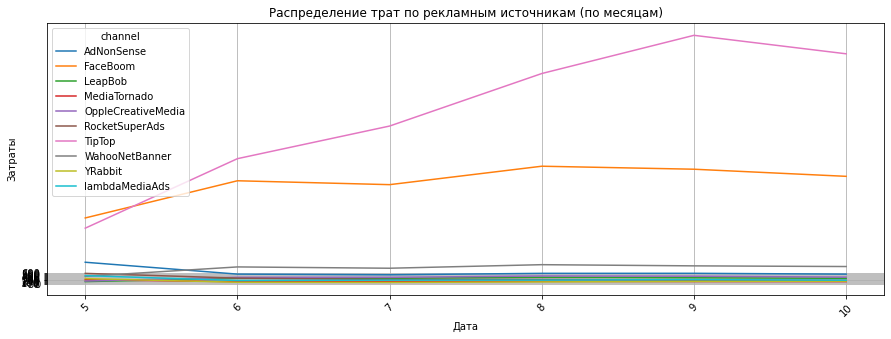

In [27]:
#изуализацию динамики изменения расходов во времени (по неделям и месяцам)
plot_data = costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')

plot_data.plot(                                             
           figsize=(15, 5),
           grid=True, 
           rot=45,        
           label='Распределение трат по рекламным источникам',                     
           legend=True,
) 

plt.yticks(np.arange(0, 650, 50)) #зададим шаг по oy
plt.title('Распределение трат по рекламным источникам (по месяцам)')
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()

In [28]:
#создадим датафрейм с источниками привлечения пользователей, которые отстают от лидирующих платформ TipTop и FaceBoom
small_channels = costs.query('channel != "TipTop" & channel != "FaceBoom"').sort_values(by='costs', ascending=False)

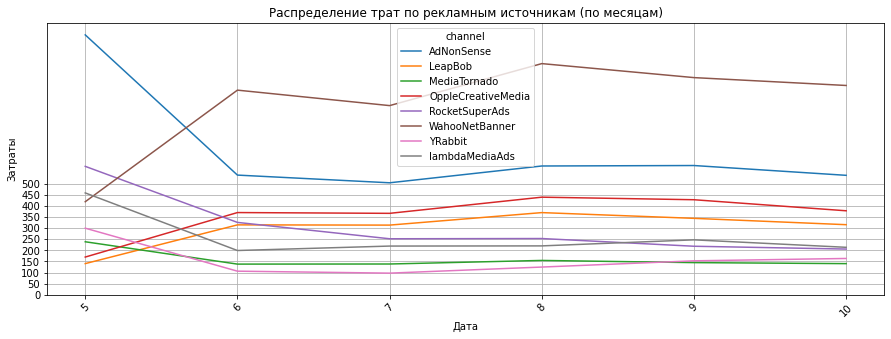

In [29]:
small_channels_plot = small_channels.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')

small_channels_plot.plot(                                             
           figsize=(15, 5),
           grid=True, 
           rot=45,        
           label='Распределение трат по рекламным источникам',                     
           legend=True,
) 

plt.yticks(np.arange(0, 550, 50)) #зададим шаг по oy
plt.title('Распределение трат по рекламным источникам (по месяцам)')
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()

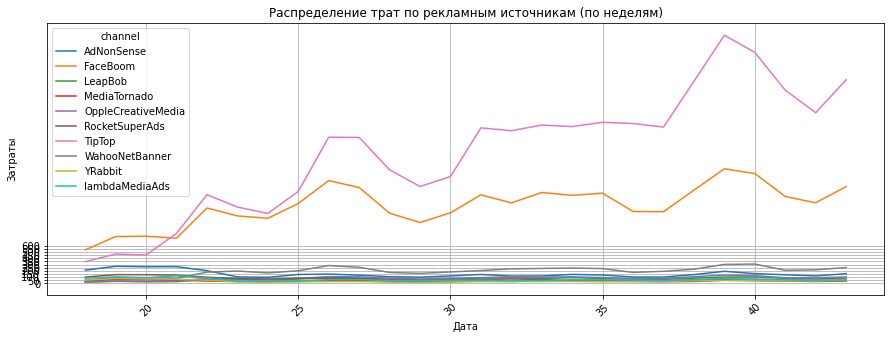

In [30]:
#визуализация динамики изменения расходов во времени (по неделям и месяцам)
plot_data = costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')

plot_data.plot(                                             
           figsize=(15, 5),
           grid=True, 
           rot=45,        
           label='Распределение трат по рекламным источникам',                     
           legend=True,
) 

plt.yticks(np.arange(0, 650, 50)) #зададим шаг по oy
plt.title('Распределение трат по рекламным источникам (по неделям)')
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()

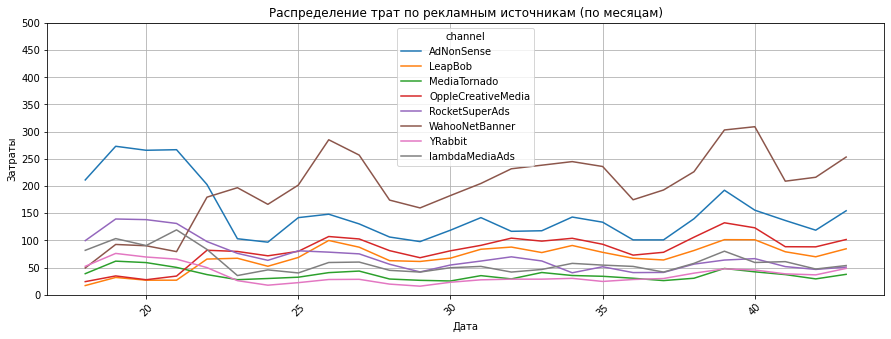

In [31]:
small_channels_plot = small_channels.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')

small_channels_plot.plot(                                             
           figsize=(15, 5),
           grid=True, 
           rot=45,        
           label='Распределение трат по рекламным источникам',                     
           legend=True,
) 

plt.yticks(np.arange(0, 550, 50)) #зададим шаг по oy
plt.title('Распределение трат по рекламным источникам (по месяцам)')
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()

Графики показывают высокую стоимость привлечения пользователей из каналов **FaceBoom** и **TipTop**. Остальные рекламные каналы значительно выигрывают по этому показателю и показывают более сглаженную динамику. При рассмотрении динамики в отрыве от двух лидирующих каналов становится ясно, что заметно растут расходы на привлечение пользователей из WahooNetBanner и одновременно снизились расходы на AdNonSense.

Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

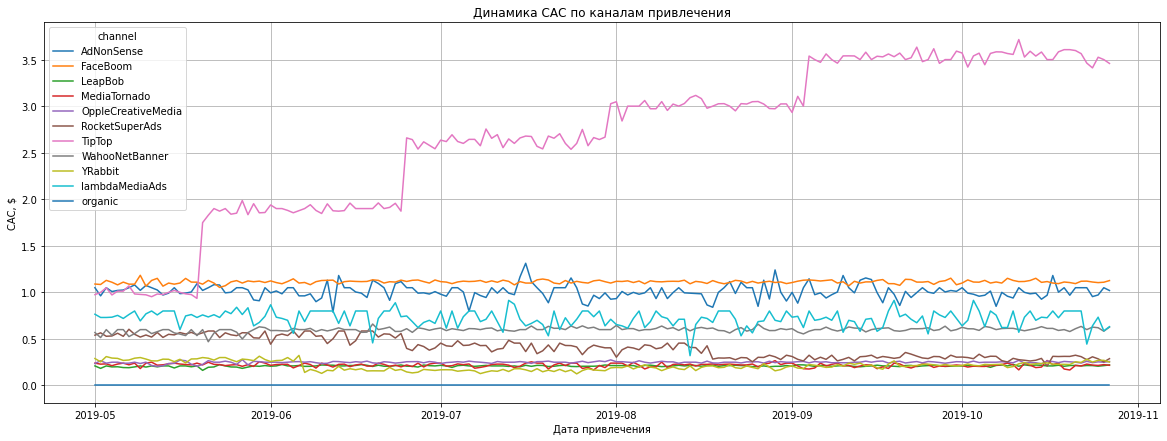

In [32]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(20, 7))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Наиболее высокую динамику показывает канал **TipTop**. Этот источник продаж наиболее - дорогостоящий, в то время как для остальных CAC более равномерный.

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также построим графики динамики LTV, CAC и ROI.

Исключим органический траффик из каналов привлечения для более корректных расчётов. Так как нам важно исследовать платные источники привлечения

In [33]:
profiles = profiles.query('channel !="organic"')

In [34]:
horizon_days = 14
observation_date = profiles['dt'].max()
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)

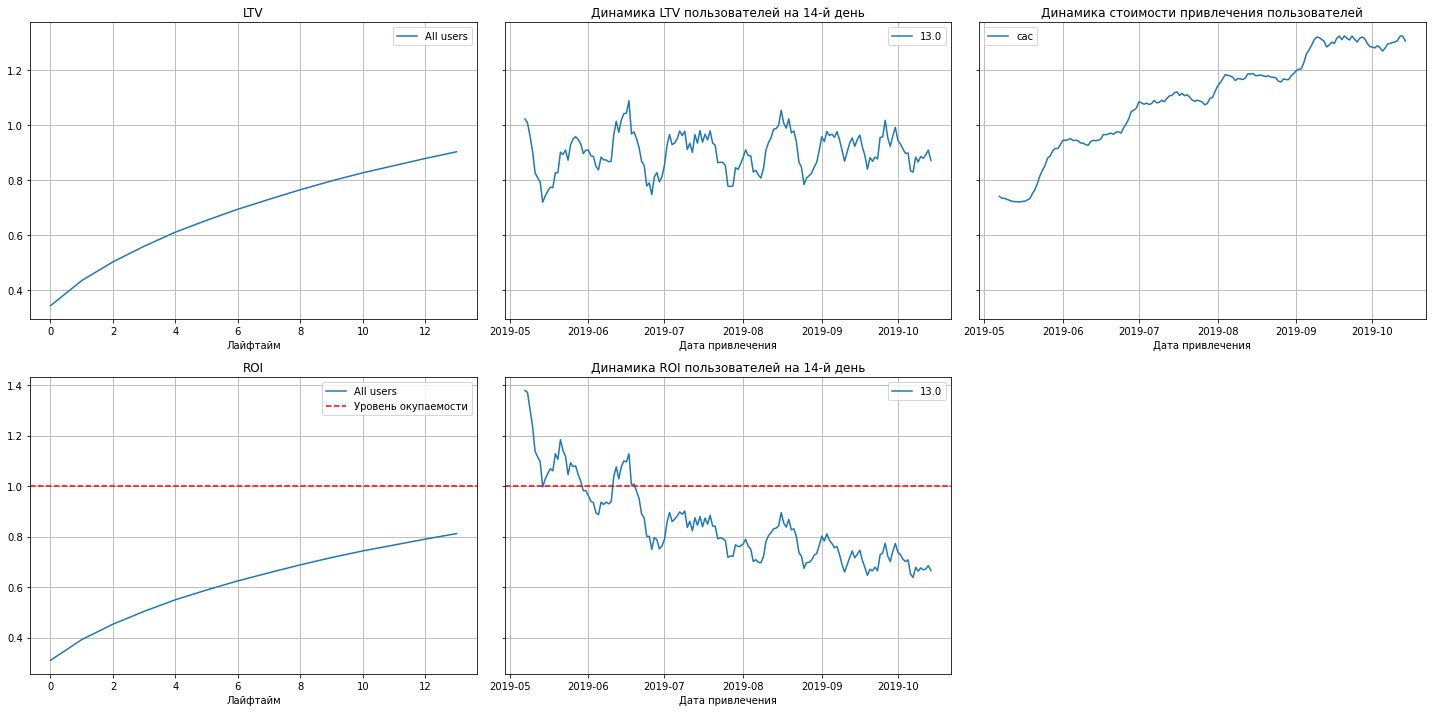

In [35]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Полученные графики показывают, что общая окупаемость привлечённых пользователей происходит достаточно быстро, буквально в течение двух недель. Но при этом в течение года показана отрицательная динамика, которая сглаживается к концу лета. Вероятно имеет место сезонный фактор.

Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.

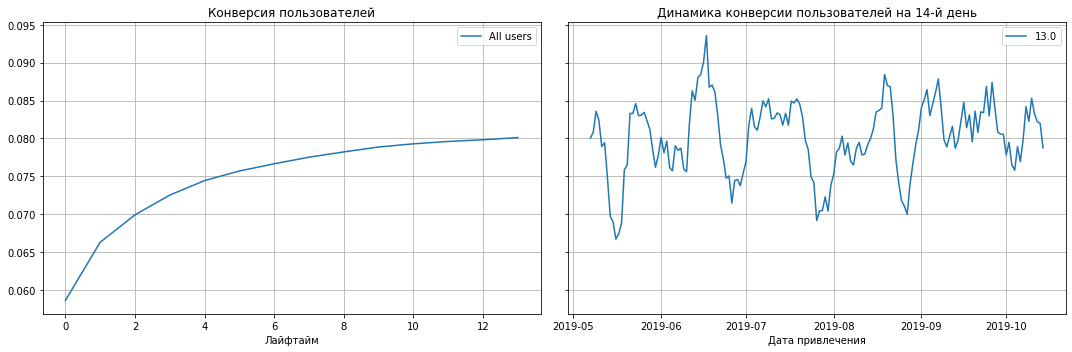

In [36]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_history, horizon_days)


К концу второй недели конверсия пользователей приближается к 60%. Динамика конверсии относительно стабильная.

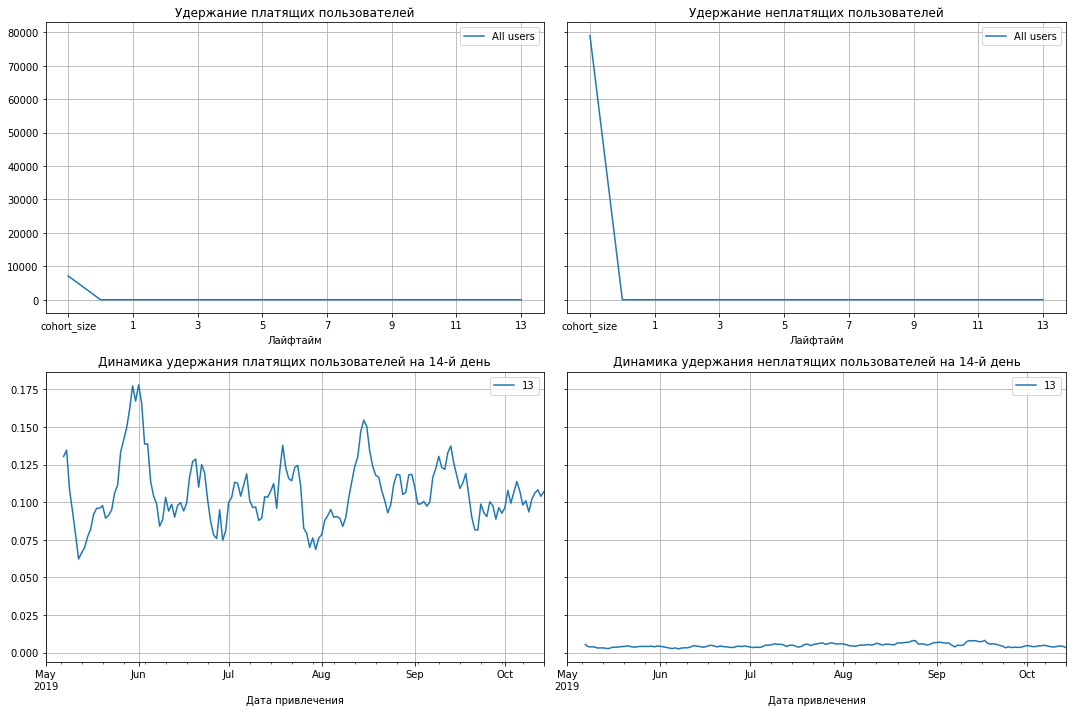

In [37]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days)

plot_retention(retention_grouped, retention_history, horizon_days)


У меня возникли сложности с интерпретацией графиков по коэффициенту удержания. Буду рад помощи.

Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

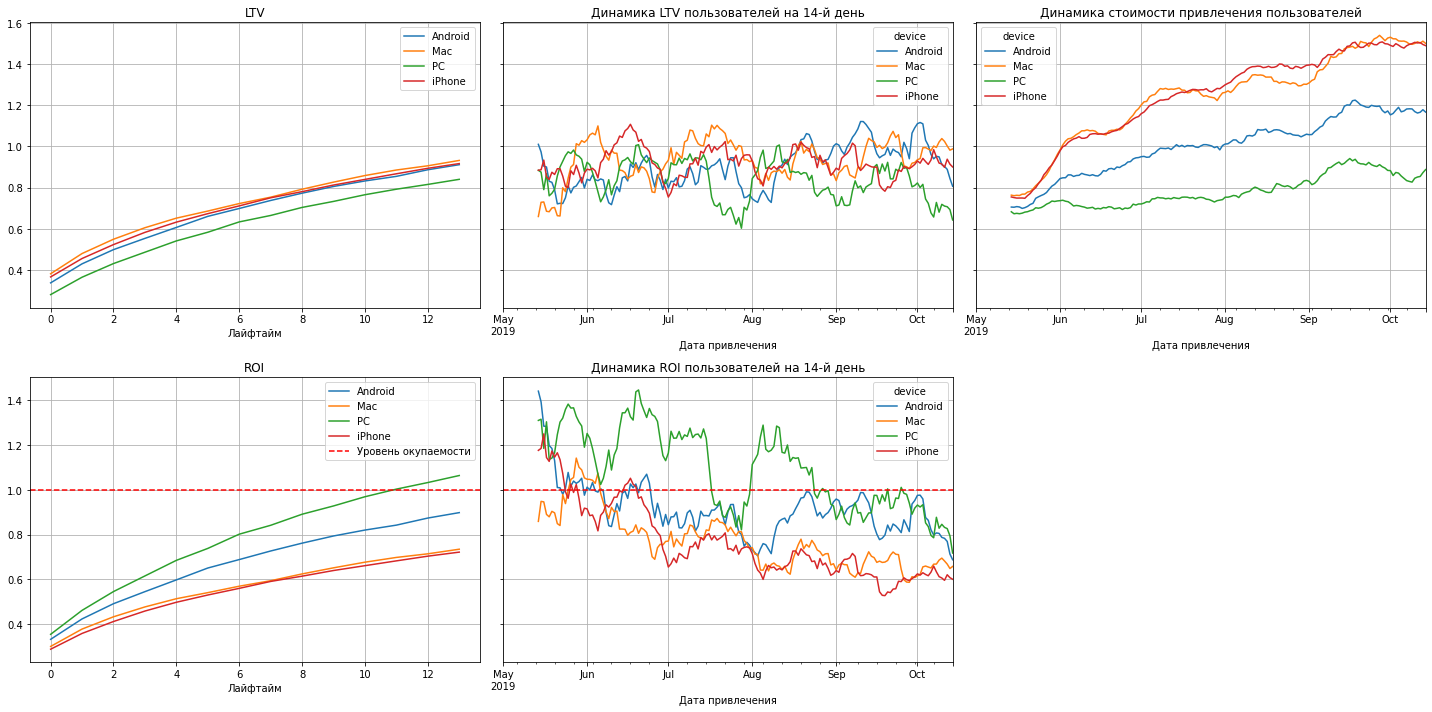

In [38]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

LTV для всех типов устройств, кроме PC примерно одинаков. Динамика стоимости привлечения пользователей выше у пользователей устройств компании Apple. Быстрее всего окупается привлечение пользователей PC, так же как медленнее снижается динамика возврата инвестиций в разрезе месяцев.

Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

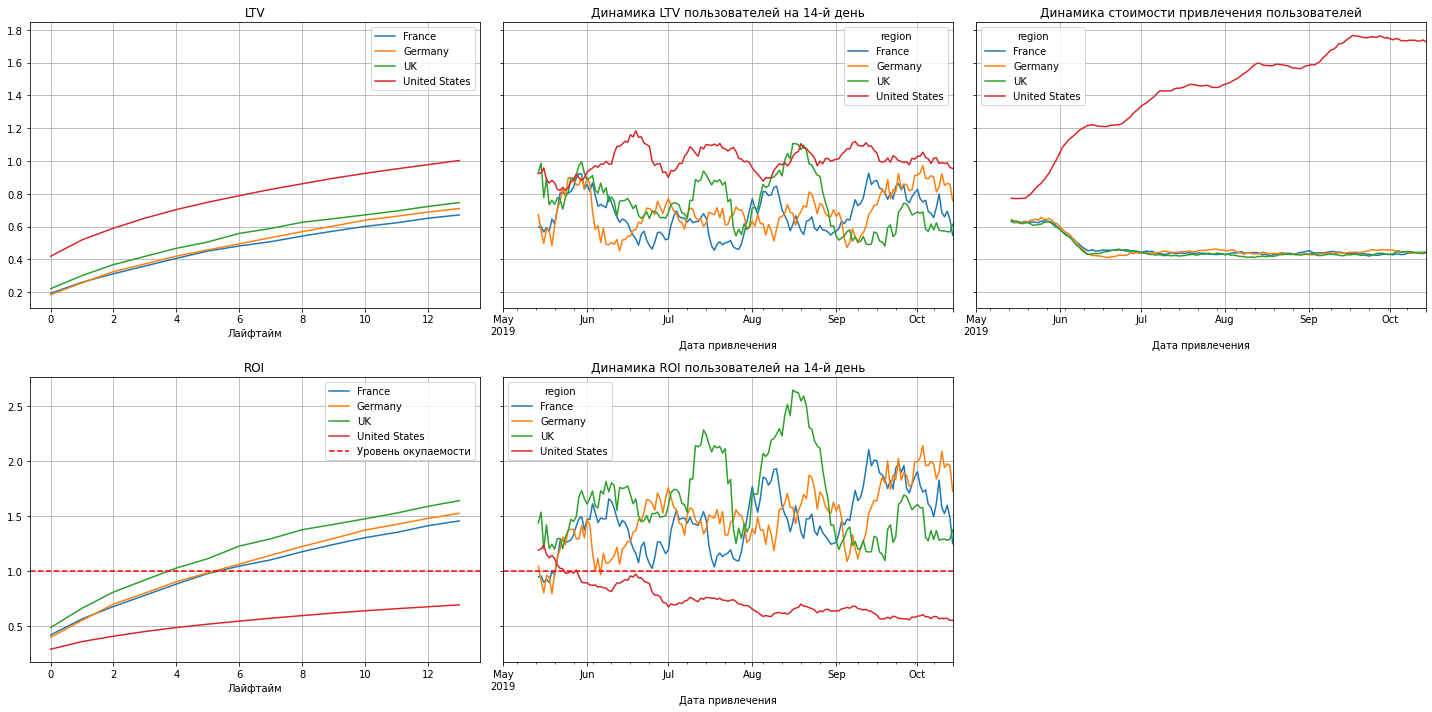

In [39]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

LTV пользователей из Соединённых Штатов Америки выше, чем в других странах. При этом для американцев заметно выше динамика стоимости привлечения пользователей и возврат инвестиций происходит гораздо дольше.

Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

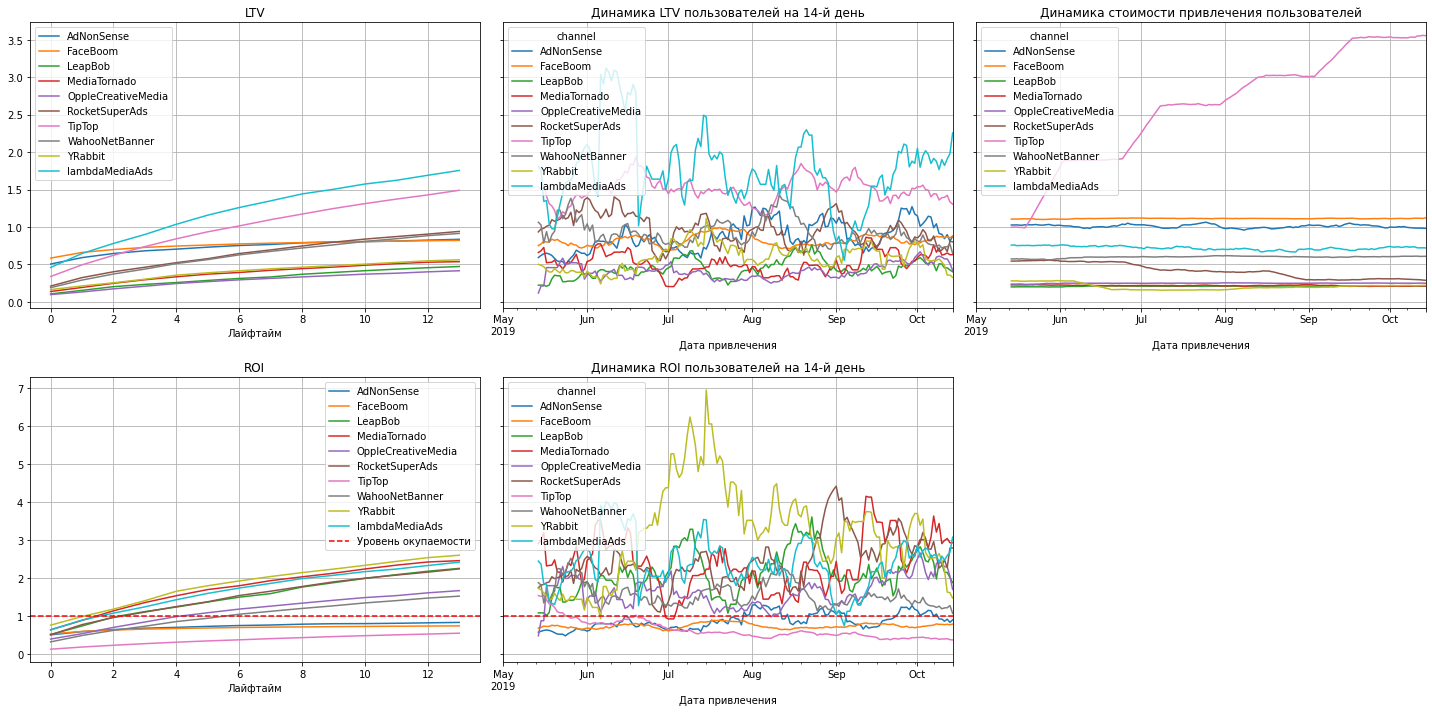

In [40]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

LTV пользователей, привлечённых lambdaMediaAds и Tip-Top очевидно выше, чем для других каналов. Стоимость привлечения для них тоже выше, кроме того динамика стоимости очень высока для Tip Top.

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей. 

Заметно выделяются проблемные каналы привлечения пользователей. В первую очередь это касается Tip Top. Также наиболее дорого удержание пользователей из США. Конверсия пользователей FaceBoom была самой высокой, но удержание платящих пользователей было самое низкое.

- Сформулируйте рекомендации для отдела маркетинга.

Рвнок США самый перспективный для продвижения платных услуг. Так как там наиболее платёжеспособная аудитория. Это основной рынок для нашего приложения. Нужно пересмотреть бюджет в сторону более выгодных каналов привлечения пользователей и устройств.